In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import os
from PIL import Image, ImageOps

In [2]:
mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [15]:
def show(img):
    #print(img.shape)
    plt.imshow(img, cmap=plt.get_cmap('gray_r'))
    plt.show()

In [4]:
#img = cv2.imread('indian_plates/Audi-A4-528794d.png')

In [4]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [25]:
def process(img):
    to_show = img.copy()
    "pre process"
    #contrast = cv2.addWeighted(img, -1.5, np.zeros(img.shape, img.dtype), 0,0)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    thresh = cv2.adaptiveThreshold(gray,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31 ,4)
    show(thresh)
    #ret, new = cv2.threshold(gray,0,255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    #show(new)
    #thresh = cv2.adaptiveThreshold(blur,255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11 ,2)
    #_, thresh = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #_, thresh = cv2.threshold(gray,220 , 255, cv2.THRESH_BINARY_INV)
    
    blur = cv2.medianBlur(thresh, 3, 0)

    """
    kernel = np.ones((3,3),np.uint8)
    thresh = cv2.erode(thresh,kernel, iterations = 1)
    newkernel = np.ones((3,3),np.uint8)
    thresh = cv2.dilate(thresh, newkernel, iterations = 1)
    """
    
    "find countours"
    contours,hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    regions = []
    for c in contours:
        #if cv2.contourArea(c)> 100:
        [x,y,w,h] = cv2.boundingRect(c)
        if w > thresh.shape[0]/6 and w < thresh.shape[0]/2 and h > thresh.shape[1]/10 and h < thresh.shape[1]*2/3 :
            regions.append((x,y,w,h))
            cv2.rectangle(to_show, (x,y), (x+w,y+h), (0,0,255), 2)
            
    regions = sorted(regions, key=lambda x: x[0])
        
    return thresh,regions, to_show


In [6]:
def predictletter(img):
    img  = img.reshape(1,28,28,1)
    img = img/255
    i = model.predict(img)
    #print(i)
    i = np.argmax(i)
    #print(i)
    ans = mapping[i]
    #print(ans)
    return ans

In [7]:

def recognition(img, bg_colour):
    #show(img)
    
    border = 4
    if img.shape[1]>img.shape[0]:
        x = img.shape[1]
        y = img.shape[0]
        extra = x - y
        a = int(extra/2)
        b = int((extra+1)/2)
        top = np.full((x+2*border,x+2*border), bg_colour)
        top[a+border:a+y+border,border:border+x] = img[:]
        
    else:
        x = img.shape[0]
        y = img.shape[1]
        extra = x - y
        a = int(extra/2)
        b = int((extra+1)/2)
        top = np.full((x+2*border,x+2*border), bg_colour)
        top[border:border+x,a+border:a+y+border] = img[:]
        
    
    basewidth = 28
    img = Image.fromarray(top)
    #show(top)
    img = img.resize((basewidth, basewidth), Image.ANTIALIAS)
    img = ImageOps.grayscale(img) 
    img = np.array(img)
    
    return img

In [8]:
def extract(thresh, regions):
    ans = []
    segments = []
    for i in regions:
        x = i[0]
        y = i[1]
        w = i[2]
        h = i[3]
        charimg = thresh[y:y+h,x:x+w]
        #show(charimg)
        charimg2 = recognition(charimg, 0)
        #show(charimg2)
        segments.append(charimg2)
        ans.append(predictletter(charimg2))
    
    ans = np.array(ans)
    segments = np.array(segments)
    return ans, segments

In [9]:
def predict(img):
    thresh, regions, to_show = process(img)
    
    return extract(thresh, regions)

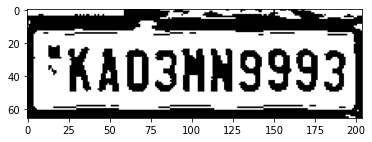

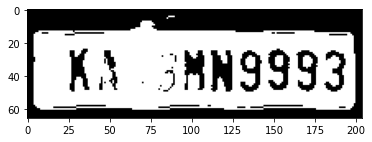

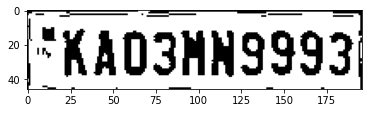

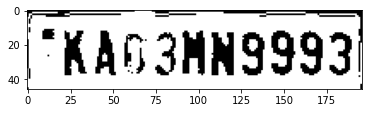

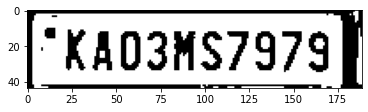

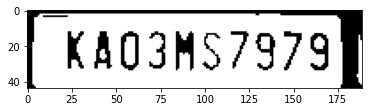

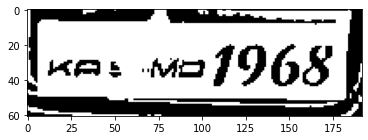

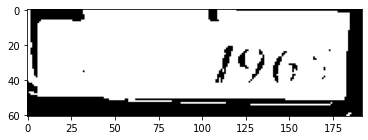

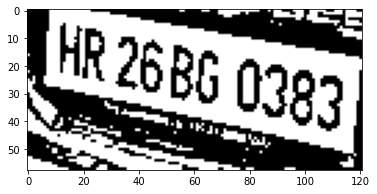

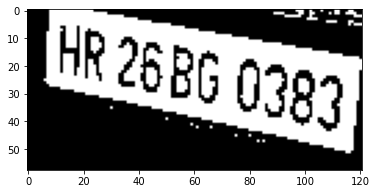

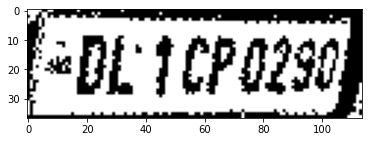

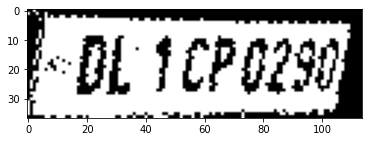

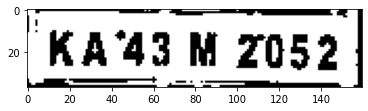

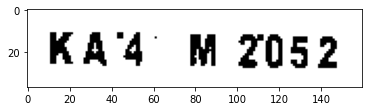

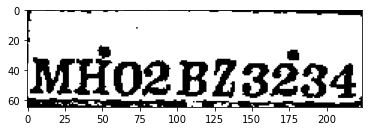

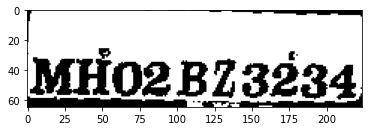

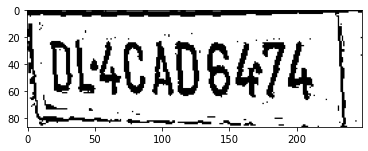

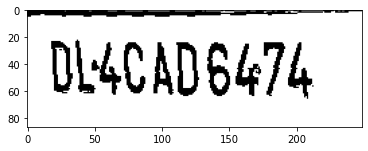

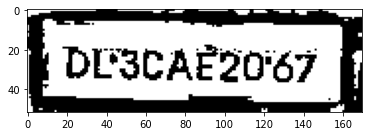

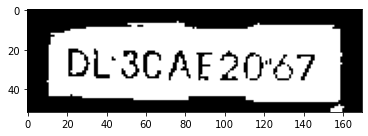

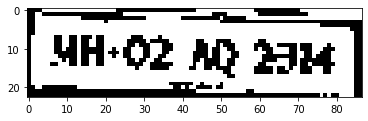

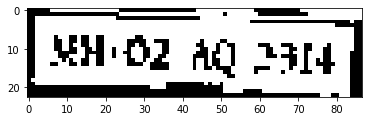

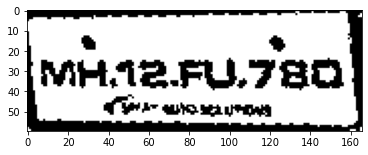

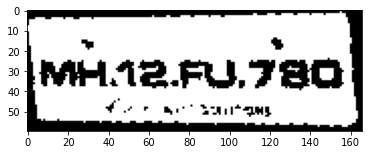

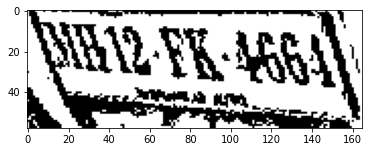

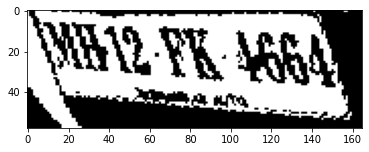

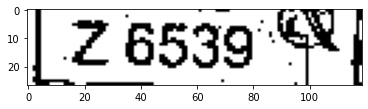

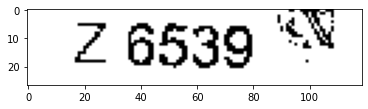

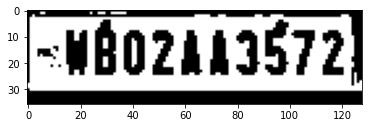

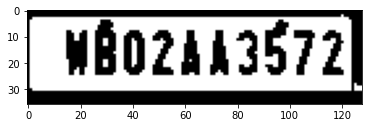

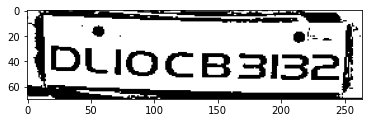

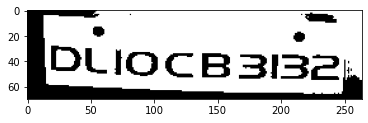

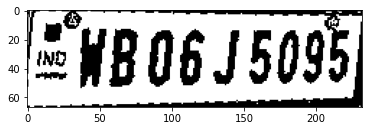

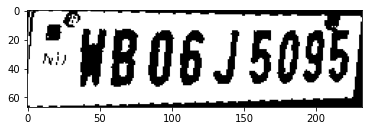

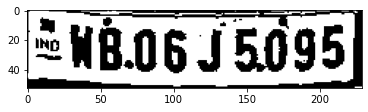

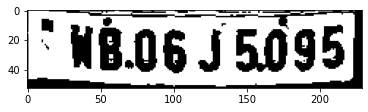

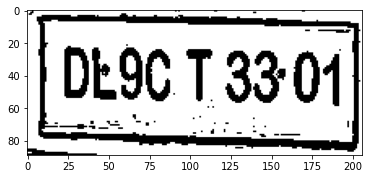

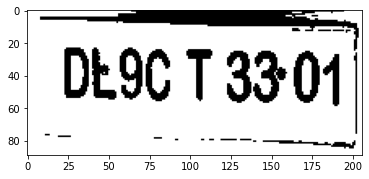

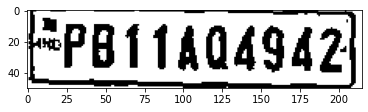

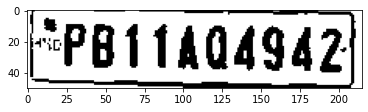

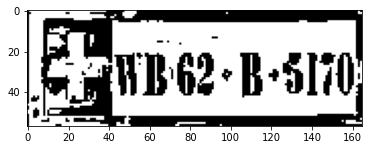

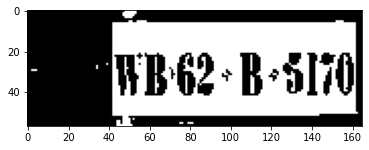

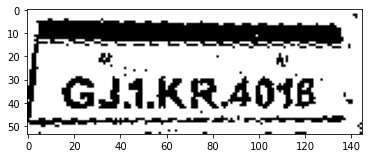

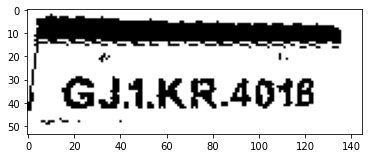

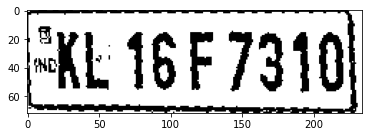

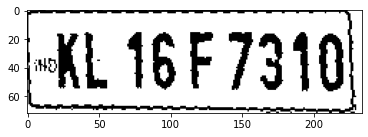

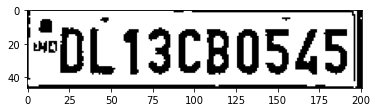

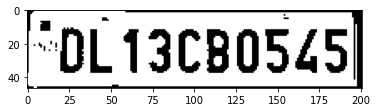

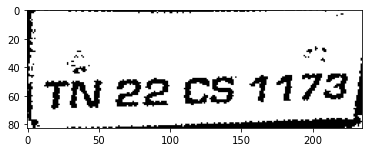

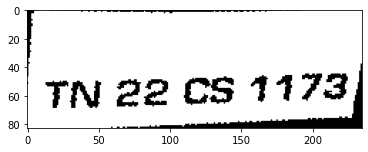

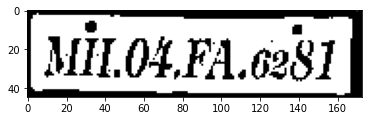

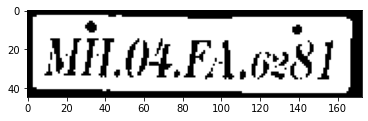

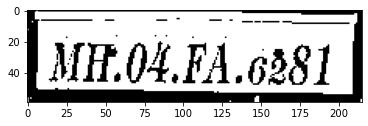

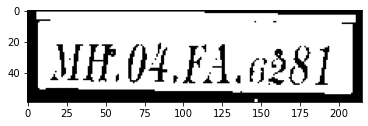

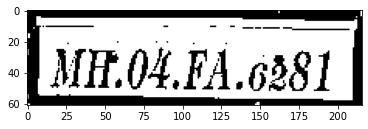

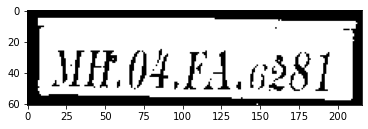

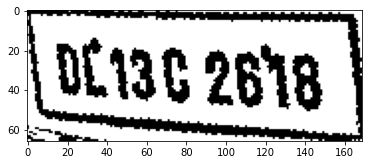

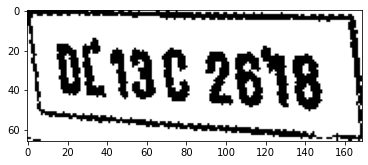

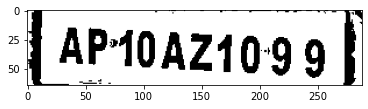

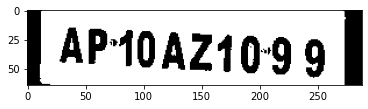

KeyboardInterrupt: 

In [26]:
for i in os.listdir('indian_plates'):
    folder = os.path.join('indian_plates',i)
    img = cv2.imread(folder)
    ans, segments = predict(img)
    

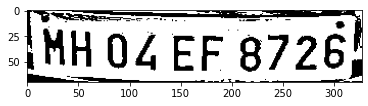

TypeError: Image data of dtype object cannot be converted to float

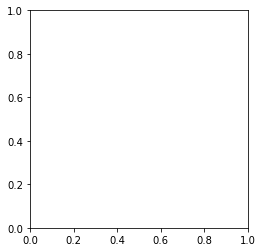

In [20]:
if __name__ == '__main__':    
    img = cv2.imread('1.png')
    ans ,segments = predict(img)
    
#KA03HN9993